In [89]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import folium
from folium import plugins

from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.grid_search import GridSearchCV
from sklearn import preprocessing

injury_df = pd.read_excel('data/vanquishcollisions1/Collision Data/Detailed collision data/VGH Injury Data/VGH 2008-2017.xlsx')

In [3]:
injury_df.head()

,CoV ID,Collision Time Range,Collision Date,Modes,Injury Type,Age,Gender,Latitude,Longitude
0,1,0:00-2:59,2008-01-01,Veh-Veh,Minor,50-59,F,49.266410,-123.100813
1,2,21:00-23:59,2008-01-03,Veh-Veh,Minor,30-39,F,49.260201,-123.101075
2,3,21:00-23:59,2008-01-03,Veh-Veh,Minor,30-39,F,49.284063,-123.097861
3,4,21:00-23:59,2008-01-04,Veh-Veh,Minor,30-39,M,49.260201,-123.101075
4,5,12:00-14:59,2008-01-04,Veh-Veh,Minor,20-29,F,49.284004,-123.121739


In [4]:
injury_df.describe()

,CoV ID,Latitude,Longitude
count,10356.000000,10356.000000,10356.000000
mean,5178.500000,49.249814,-123.105846
std,2989.664028,0.022947,0.037290
min,1.000000,49.198181,-123.219629
25%,2589.750000,49.232715,-123.132505
50%,5178.500000,49.256396,-123.101519
75%,7767.250000,49.267122,-123.077399
max,10356.000000,49.315553,-123.023358


In [5]:
injury_df["Latitude"].mean()

49.24981367600353

In [6]:
injury_df['Latitude'] = pd.Series(injury_df['Latitude'], dtype='float32')
injury_df['Longitude'] = pd.Series(injury_df['Longitude'], dtype='float32')

injury_map = folium.Map(location=[injury_df['Latitude'].mean(), injury_df['Longitude'].mean()],
                   zoom_start=11)

injury_map 

In [7]:
# Dataset is too large to plot nicely, take sample

injury_sample = injury_df.sample(frac=0.1, replace=False)

In [8]:
for index, row in injury_sample.iterrows():
    folium.CircleMarker([row['Latitude'], row['Longitude']],
                        radius=1,
                        popup= 'Age: {} \nInjury Type:{} \nMode:{} \nCollision Date:{}'.format(row['Age'],
                                                                                               row['Injury Type'],
                                                                                               row['Modes'],
                                                                                               row['Collision Date']),
                        fill_color="#3db7e4", # divvy color
                       ).add_to(injury_map)
    
    
injury_map

In [9]:
# convert to (n, 2) nd-array format for heatmap
injury_array = injury_sample[['Latitude', 'Longitude']].as_matrix()

# plot heatmap
injury_map.add_child(plugins.HeatMap(injury_array.tolist(), radius=15))
injury_map

In [65]:
# Filter for only Ped and cyclists
modes = injury_df["Modes"].unique()

modes = modes[~pd.isna(modes)]

cyl_ped = []

for mode in modes:
    if ('Cyl'in mode or 'Ped' in mode):
        cyl_ped.append(mode)   

injury_filt = injury_df[(injury_df["Modes"].isin(cyl_ped))]

print(injury_filt)

       CoV ID Collision Time Range Collision Date       Modes Injury Type  \
5           6          21:00-23:59     2008-01-05     Veh-Ped       Minor   
6           7          21:00-23:59     2008-01-02  Single Cyl       Minor   
9          10          21:00-23:59     2008-01-05     Veh-Ped       Minor   
10         11            3:00-5:59     2008-01-05     Ped-Unk      Severe   
15         16          21:00-23:59     2008-01-09     Veh-Ped       Minor   
16         17          18:00-20:59     2008-01-09     Veh-Ped       Minor   
19         20          18:00-20:59     2008-01-10     Veh-Ped       Minor   
20         21          18:00-20:59     2008-01-10     Veh-Ped       Minor   
29         30          18:00-20:59     2008-01-13     Veh-Ped       Minor   
46         47          15:00-17:59     2008-01-23     Veh-Ped       Minor   
54         55          12:00-14:59     2008-01-28     Veh-Cyl       Minor   
63         64          21:00-23:59     2008-02-01  Single Cyl       Minor   

In [69]:
# Bin the 

ped_all = {"Veh-Ped", "Ped-Unk", "Mot-Ped", "Single Ped"}
cyl_all = {"Single Cyl", "Veh-Cyl", "Cyl-Unk", "Cyl-Cyl", "Mot-Cyl"}

def _bin(mode):
    if mode == "Cyl-Ped":
        return "Cyl-Ped"
    elif mode in ped_all:
        return "Ped-All"
    else:
        assert mode in cyl_all
        return "Cyl-All"

df_binned = injury_filt.copy()
df_binned["Modes"] = df_binned["Modes"].apply(_bin)

print (df_binned)

       CoV ID Collision Time Range Collision Date    Modes Injury Type    Age  \
5           6          21:00-23:59     2008-01-05  Ped-All       Minor  20-29   
6           7          21:00-23:59     2008-01-02  Cyl-All       Minor  30-39   
9          10          21:00-23:59     2008-01-05  Ped-All       Minor  40-49   
10         11            3:00-5:59     2008-01-05  Ped-All      Severe    70+   
15         16          21:00-23:59     2008-01-09  Ped-All       Minor  20-29   
16         17          18:00-20:59     2008-01-09  Ped-All       Minor  20-29   
19         20          18:00-20:59     2008-01-10  Ped-All       Minor  40-49   
20         21          18:00-20:59     2008-01-10  Ped-All       Minor  50-59   
29         30          18:00-20:59     2008-01-13  Ped-All       Minor  20-29   
46         47          15:00-17:59     2008-01-23  Ped-All       Minor  20-29   
54         55          12:00-14:59     2008-01-28  Cyl-All       Minor  20-29   
63         64          21:00

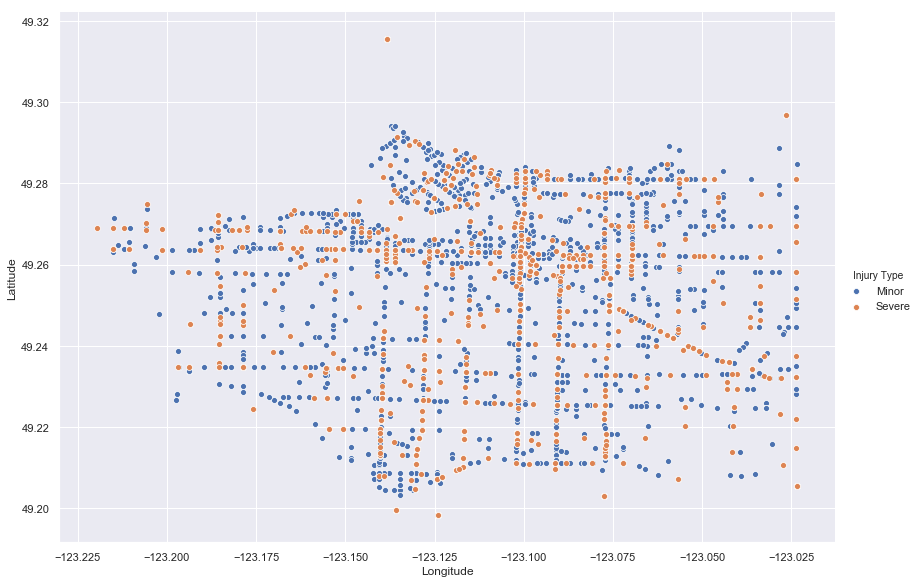

In [70]:
# Cluster collisions. 
# Make predictions by collision mode
# Make predictions by severity

sns.pairplot(x_vars = ["Longitude"], 
             y_vars = ["Latitude"], 
             data = df_binned, 
             hue = "Injury Type", 
             height=8.27, 
             aspect=11.7/8.27)

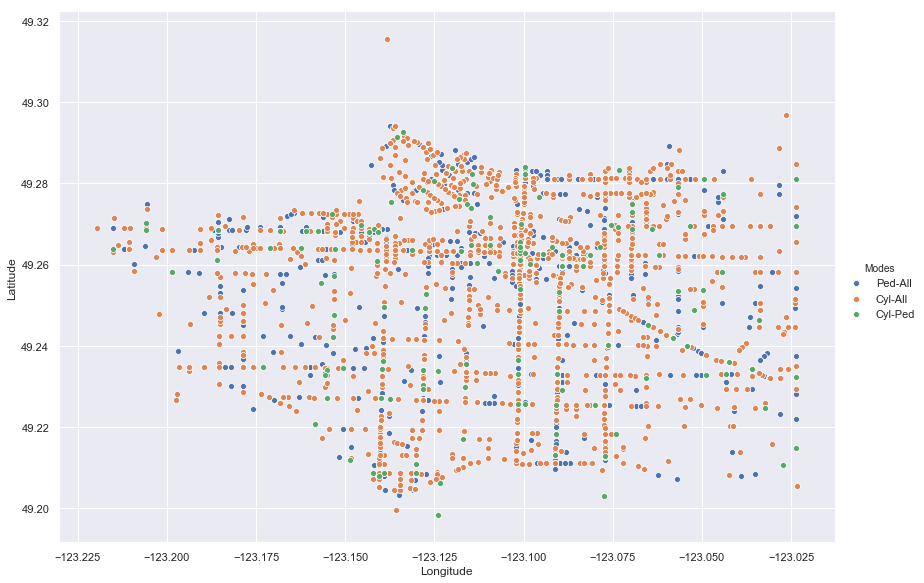

In [83]:
sns.pairplot(x_vars = ["Longitude"], 
             y_vars = ["Latitude"], 
             data = df_binned, 
             hue = "Modes", 
             height=8.27, 
             aspect=11.7/8.27)

In [86]:
le = preprocessing.LabelEncoder()


X = df_binned.loc[:, ['Longitude', 'Latitude']]
Y = df_binned.loc[:, 'Modes']
                  
# Split the data into a testing and training set so we can test the model accuracy.
X_train, X_test, Y_train, Y_test = train_test_split(
        X, # Independent variables
        Y, # Independent variable
        test_size=0.33) 

print('Training set length: {}.\nTest set length: {}'.format(X_train.shape[0], X_test.shape[0]))


Training set length: 2495.
Test set length: 1229


In [87]:
knn = KNeighborsClassifier(n_neighbors = 5)
knn.fit(X_train, Y_train)

print ("Training Accuracy {}".format(knn.score(X_train, Y_train)))
print ("Testing Accuracy {}".format(knn.score(X_test, Y_test)))

Training Accuracy 0.6537074148296593
Testing Accuracy 0.5069161920260374


In [88]:
k_range = list(range(1, 200))
param_grid = dict(n_neighbors=k_range)

grid = GridSearchCV(knn, param_grid, cv=10, scoring='accuracy')
grid.fit(X, Y)
grid.grid_scores_

print(grid.best_score_)
print(grid.best_params_)
print(grid.best_estimator_)

0.5714285714285714
{'n_neighbors': 94}
KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=94, p=2,
           weights='uniform')
